In [137]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [40]:
df = pd.read_csv('../data/treated_data/data.csv')
df.head()

,id,email_content,email_type
0,00001.7848dde101aa985090474a91ec93fcf0,\n\n\n\n\n\n\n\n\n\n\n\n\n\nSave up to 70% on ...,spam
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\nURL\n\n2) Slim D...,spam
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\nURL\n\n2) Slim D...,spam
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,spam
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n1) Slim Down ...,spam


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3000 non-null   object
 1   email_content  2999 non-null   object
 2   email_type     3000 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB


In [39]:
# Checando e dropando NaN 

print(df.isna().sum())
df_tr1 = df.dropna()

id               0
email_content    1
email_type       0
dtype: int64


In [73]:
# Checando emails duplicados

print(f"Duplicated emails: {df_tr1['email_content'].duplicated().sum()}")
df_tr2 = df_tr1[~df_tr1['email_content'].duplicated()]

Duplicated emails: 90


In [89]:
# Verificando proporções dos targets

df_tr2['email_type'].value_counts(normalize=True)

ham     0.845995
spam    0.154005
Name: email_type, dtype: float64

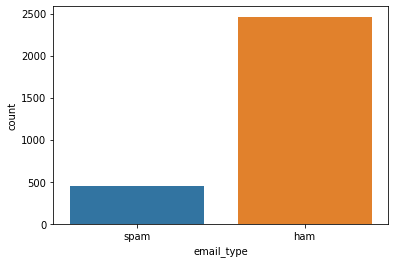

In [101]:
ax = sns.countplot(x=df_tr2['email_type'])
# count.text(x,y,s)

In [121]:
# Train test split

X = df_tr2['email_content']
y = df_tr2['email_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [133]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)

In [135]:
forest_clf = RandomForestClassifier(n_estimators=500, random_state=42)
forest_clf.fit(X_train_vec, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [138]:
# Avaliando

X_test_vec = vectorizer.transform(X_test)
y_pred = forest_clf.predict(X_test_vec)

# Verificando acurácia

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       492
        spam       0.99      0.83      0.90        90

    accuracy                           0.97       582
   macro avg       0.98      0.92      0.94       582
weighted avg       0.97      0.97      0.97       582



In [ ]:
# Add email type
# Remove /n, email adresses
# lowercase all email contents